<a href="https://colab.research.google.com/github/luckyos-code/mia-covid/blob/main/wandb_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import wandb

In [ ]:
# consistent line settings and naming scheme and ordering
MARKERS = {
    'ResNet18-Standard' : 'o',
    'ResNet18-ImageNet' : 'v',
    'ResNet18-Pneumonia' : '^',
    'ResNet18-tanh-Standard' : '<',
    'ResNet18-tanh-ImageNet' : '>',
    'ResNet18-tanh-Pneumonia' : 's',
    'ResNet50-Standard' : 'p',
    'ResNet50-ImageNet' : '*',
    'ResNet50-Pneumonia' : 'd',
    'ResNet50-tanh-Standard' : 'P',
    'ResNet50-tanh-ImageNet' : '$m$',
    'ResNet50-tanh-Pneumonia' : 'X',
}

COLORS = {
    'ResNet18-Standard' : 'C0',
    'ResNet18-ImageNet' : 'C1',
    'ResNet18-Pneumonia' : 'C2',
    'ResNet18-tanh-Standard' : 'C3',
    'ResNet18-tanh-ImageNet' : 'C4',
    'ResNet18-tanh-Pneumonia' : 'C5',
    'ResNet50-Standard' : 'C6',
    'ResNet50-ImageNet' : 'C7',
    'ResNet50-Pneumonia' : 'C8',
    'ResNet50-tanh-Standard' : 'C9',
    'ResNet50-tanh-ImageNet' : 'gold',
    'ResNet50-tanh-Pneumonia' : 'darkseagreen',
}

In [ ]:
api = wandb.Api()
runs = api.runs("ll95wyqa/mia-covid")

# dicts structure: dataset_keys->epsilon_keys,  epsilon_keys->model_keys, model_keys->result_keys
rows_list = []
for run in runs:
    if run.state == "finished":
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary = run.summary._json_dict
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config = {k: v for k,v in run.config.items() if not k.startswith('_')}
        # .name is the human-readable name of the run.
        #name_list.append(run.name)

        # replace eps=9999.0 with 100.0 and $\infty$' when plotting for better graph and naming
        target_eps = 9999.0 if config['target_eps'] == None else float(config['target_eps'])
        # give model name for comparing to lowercased names in colors
        opt_activation = '' if config['activation']=='relu' else '-tanh'
        opt_pretraining = 'standard' if not config['pretraining'] else config['pretraining']
        variant = config['architecture'] + opt_activation + '-' + opt_pretraining
        # no membership advantage when f1-score is 0.0
        adv95 = (np.nan, np.nan) if np.round(summary['f1-score']*100,1) == 0.0 else (summary['adv95'][0], summary['adv95'][1])

        row = {
            'dataset': config['dataset'],
            'target_eps': target_eps,
            'variant': variant,
            'accuracy': summary['accuracy'],
            'f1-score': summary['f1-score'],
            'adv95': adv95,
        }
        rows_list.append(row)

runs_df = pd.DataFrame(rows_list, columns=['dataset', 'target_eps', 'variant', 'accuracy', 'f1-score', 'adv95'])   
#runs_df.to_csv("project.csv")

runs_df

,dataset,target_eps,variant,accuracy,f1-score,adv95
0,mnist,0.1,resnet50-tanh-imagenet,0.933000,0.932149,"(0.1776253513672949, 0.19855164863270508)"
1,mnist,1.0,resnet50-tanh-imagenet,0.966000,0.965832,"(0.18284819370330563, 0.2004228062966944)"
2,mnist,10.0,resnet50-tanh-imagenet,0.977100,0.976995,"(0.1782459681334568, 0.1966190318665432)"
3,mnist,0.1,resnet50-tanh-standard,0.276200,0.254001,"(0.12872097863219076, 0.1432690213678093)"
4,mnist,1.0,resnet50-tanh-standard,0.849600,0.846873,"(0.19678238212605528, 0.2180626178739447)"
...,...,...,...,...,...,...
75,covid,1.0,resnet18-standard,0.599558,0.000000,"(nan, nan)"
76,covid,0.1,resnet18-standard,0.599558,0.000000,"(nan, nan)"
77,covid,9999.0,resnet50-standard,0.915929,0.892655,"(0.24525603511018715, 0.2675168262467451)"
78,covid,10.0,resnet18-standard,0.712389,0.577922,"(0.2247869789820512, 0.2414206168881552)"


In [ ]:
# if run one failed add value here later
# run = api.run("ll95wyqa/mia-covid/ID")
# run.summary["accuracy"] = 
# run.summary["f1-score"] = 
# run.summary.update()

In [ ]:
runs_df.sort_values(by=['target_eps'], ascending=False).groupby(['dataset','variant']).apply(lambda grp: print(grp))

   dataset  target_eps            variant  accuracy  f1-score  \
74   covid      9999.0  resnet18-imagenet  0.968289  0.959396   
68   covid        10.0  resnet18-imagenet  0.854720  0.794148   
71   covid         1.0  resnet18-imagenet  0.599558  0.000000   
72   covid         0.1  resnet18-imagenet  0.599558  0.000000   

                                         adv95  
74   (0.24950406288951313, 0.2726373456650591)  
68  (0.24976052725288872, 0.26595942112469245)  
71                                  (nan, nan)  
72                                  (nan, nan)  
   dataset  target_eps             variant  accuracy  f1-score  \
70   covid      9999.0  resnet18-pneumonia  0.921829  0.898467   
61   covid        10.0  resnet18-pneumonia  0.715339  0.572062   
64   covid         1.0  resnet18-pneumonia  0.705000  0.543400   
65   covid         0.1  resnet18-pneumonia  0.712900  0.614300   

                                         adv95  
70   (0.2238518534370303, 0.24381499759541808)  


""


In [ ]:
runs_df.groupby(['dataset','target_eps']).apply(lambda grp: print(grp))

   dataset  target_eps                  variant  accuracy  f1-score  \
14   covid         0.1  resnet50-tanh-pneumonia  0.730088  0.694491   
17   covid         0.1   resnet50-tanh-imagenet  0.508100  0.607100   
23   covid         0.1   resnet50-tanh-standard  0.685841  0.620321   
28   covid         0.1       resnet50-pneumonia  0.599558  0.000000   
37   covid         0.1        resnet50-imagenet  0.599600  0.000000   
43   covid         0.1        resnet50-standard  0.599558  0.000000   
48   covid         0.1  resnet18-tanh-pneumonia  0.728614  0.657993   
53   covid         0.1   resnet18-tanh-imagenet  0.508100  0.609700   
58   covid         0.1   resnet18-tanh-standard  0.679941  0.629693   
65   covid         0.1       resnet18-pneumonia  0.712900  0.614300   
72   covid         0.1        resnet18-imagenet  0.599558  0.000000   
76   covid         0.1        resnet18-standard  0.599558  0.000000   

                                         adv95  
14   (0.20998418104708724, 

""


In [ ]:
# mean membership advantage for grouping datasets and eps
n_round = 2
runs_df.groupby(['dataset','target_eps'])['adv95'].apply(lambda grp: (np.round(np.mean([x[0] for x in grp if not np.isnan(x[0])]),n_round), np.round(np.mean([x[1] for x in grp if not np.isnan(x[0])]),n_round)))

dataset  target_eps
covid    0.1            (0.2, 0.22)
         1.0            (0.2, 0.22)
         10.0          (0.22, 0.23)
         9999.0        (0.23, 0.25)
mnist    0.1           (0.15, 0.17)
         1.0           (0.17, 0.19)
         10.0          (0.17, 0.19)
         9999.0        (0.19, 0.21)
Name: adv95, dtype: object

In [ ]:
# remove f1 under 50
api = wandb.Api()
runs = api.runs("ll95wyqa/mia-covid")

# dicts structure: dataset_keys->epsilon_keys,  epsilon_keys->model_keys, model_keys->result_keys
rows_list = []
for run in runs:
    if run.state == "finished":
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary = run.summary._json_dict
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config = {k: v for k,v in run.config.items() if not k.startswith('_')}
        # .name is the human-readable name of the run.
        #name_list.append(run.name)

        # replace eps=9999.0 with 100.0 and $\infty$' when plotting for better graph and naming
        target_eps = 9999.0 if config['target_eps'] == None else float(config['target_eps'])
        # give model name for comparing to lowercased names in colors
        opt_activation = '' if config['activation']=='relu' else '-tanh'
        opt_pretraining = 'standard' if not config['pretraining'] else config['pretraining']
        variant = config['architecture'] + opt_activation + '-' + opt_pretraining
        # no membership advantage when f1-score is 0.0
        adv95 = (np.nan, np.nan) if np.round(summary['f1-score']*100,1) == 0.0 or np.round(summary['f1-score']*100,1) < 50.0 else (summary['adv95'][0], summary['adv95'][1])

        row = {
            'dataset': config['dataset'],
            'target_eps': target_eps,
            'variant': variant,
            'accuracy': summary['accuracy'],
            'f1-score': summary['f1-score'],
            'adv95': adv95,
        }
        rows_list.append(row)

runs_df_f1 = pd.DataFrame(rows_list, columns=['dataset', 'target_eps', 'variant', 'accuracy', 'f1-score', 'adv95'])   

# mean membership advantage for grouping datasets and eps
n_round = 2
runs_df_f1.groupby(['dataset','target_eps'])['adv95'].apply(lambda grp: (np.round(np.mean([x[0] for x in grp if not np.isnan(x[0])]),n_round), np.round(np.mean([x[1] for x in grp if not np.isnan(x[0])]),n_round)))

dataset  target_eps
covid    0.1            (0.2, 0.22)
         1.0            (0.2, 0.22)
         10.0          (0.22, 0.23)
         9999.0        (0.23, 0.25)
mnist    0.1           (0.17, 0.19)
         1.0           (0.19, 0.21)
         10.0           (0.18, 0.2)
         9999.0        (0.19, 0.21)
Name: adv95, dtype: object

In [ ]:
def createTable(df, markers):
    table_head = [
        '\\begin{tabular}{c ccc ccc ccc ccc}',
        '\\toprule',
        ' & \\multicolumn{3}{c}{$\\eps = \\infty$} & \\multicolumn{3}{c}{$\\eps = 10$} & \\multicolumn{3}{c}{$\\eps = 1$} & \\multicolumn{3}{c}{$\\eps = 0.1$} \\\\',
        '\\cmidrule(lr){2-4} \\cmidrule(lr){5-7} \\cmidrule(lr){8-10} \\cmidrule(lr){11-13}',
        'Variant & \\%-Acc. & \\%-F1 & $\\Advinc$ & \\%-Acc. & \\%-F1 & $\\Advinc$ & \\%-Acc. & \\%-F1 & $\\Advinc$ & \\%-Acc. & \\%-F1 & $\\Advinc$ \\\\',
    ]
    table_bot = [
        '\\bottomrule',
        '\\end{tabular}',
    ]

    variants = df['variant'].unique().tolist()
    variants.sort(key=lambda i: [x.lower() for x in list(markers.keys())].index(i))

    table_rows = table_head
    model_old = ''
    for variant in variants:
        if markers:
            label = [x for x in list(markers.keys()) if x.lower()==variant].pop()
            model = label[:8]
            name = label[9:]

        if model != model_old:
            table_rows.extend([
                '\\midrule',
                '\\multicolumn{13}{c}{'+model+'} \\\\',
                '\\midrule',
            ])
            model_old = model

        table_rows.extend([
            ' '+name+' &',
        ])
        for target_eps in df.sort_values(by=['target_eps'], ascending=False)['target_eps'].unique().tolist():
            best_acc = np.round(np.max(df[df['target_eps']==target_eps]['accuracy'].values.tolist())*100, 1)
            best_f1 = np.round(np.max(df[df['target_eps']==target_eps]['f1-score'].values.tolist())*100, 1)
            best_adv_upper = np.round(np.min([x[1] for x in df[df['target_eps']==target_eps]['adv95'].values.tolist() if not np.isnan(x[1])]), 2)

            result = df[(df['variant']==variant) & (df['target_eps']==target_eps)]
            acc = np.round(result['accuracy'].values[0]*100, 1)
            acc_str = str(acc) if acc != best_acc else '\\textbf{'+str(acc)+'}'
            f1 = np.round(result['f1-score'].values[0]*100, 1)
            f1_str = str(f1) if f1 != best_f1 else '\\textbf{'+str(f1)+'}'
            adv95 = np.round(result['adv95'].values[0], 2)
            adv_str = str('%.2f'%adv95[0])+'--'+str('%.2f'%adv95[1]) if adv95[1] != best_adv_upper else '\\textbf{'+str('%.2f'%adv95[0])+'--'+str('%.2f'%adv95[1])+'}'

            if np.isnan(adv95[0]):
                adv_str = 'NA'
                acc_str = 'NA'
            
            table_rows.extend([
                '  '+acc_str+' & '+f1_str+' & '+adv_str+' &',
            ])
        table_rows[-1] = table_rows[-1][:-1] + '\\\\'

    table_rows.extend([
        *table_bot,
    ])
            
    return table_rows

In [ ]:
for dataset in runs_df['dataset'].unique():
    print(dataset)
    table = createTable(runs_df[runs_df['dataset']==dataset], markers=MARKERS)
    [print(row) for row in table]
    print('\n')

mnist
\begin{tabular}{c ccc ccc ccc ccc}
\toprule
 & \multicolumn{3}{c}{$\eps = \infty$} & \multicolumn{3}{c}{$\eps = 10$} & \multicolumn{3}{c}{$\eps = 1$} & \multicolumn{3}{c}{$\eps = 0.1$} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
Variant & \%-Acc. & \%-F1 & $\Advinc$ & \%-Acc. & \%-F1 & $\Advinc$ & \%-Acc. & \%-F1 & $\Advinc$ & \%-Acc. & \%-F1 & $\Advinc$ \\
\midrule
\multicolumn{13}{c}{ResNet18} \\
\midrule
 Standard &
  \textbf{99.5} & \textbf{99.5} & \textbf{0.18--0.20} &
  95.9 & 95.9 & 0.18--0.20 &
  90.2 & 90.1 & 0.19--0.21 &
  24.3 & 19.9 & 0.13--0.15 \\
 ImageNet &
  \textbf{99.5} & \textbf{99.5} & \textbf{0.18--0.20} &
  95.2 & 95.1 & 0.18--0.20 &
  38.0 & 35.2 & \textbf{0.13--0.14} &
  14.7 & 12.7 & 0.15--0.17 \\
 tanh-Standard &
  99.2 & 99.2 & 0.19--0.22 &
  95.1 & 95.0 & 0.20--0.22 &
  92.4 & 92.3 & 0.20--0.22 &
  72.6 & 71.5 & 0.16--0.18 \\
 tanh-ImageNet &
  99.0 & 99.0 & 0.19--0.21 &
  \textbf{97.8} & \textbf{97.8} & 0.19--0.20

In [ ]:
def theoretical_eps_bound(eps):
    return np.exp(eps) - 1 # +1e-4 for covid and +1e-5 for mnist (both neglectable)

In [ ]:
budgets = np.sort(runs_df['target_eps'].unique())
print('DP Bounds:', [*[(el, theoretical_eps_bound(el)) for el in budgets[:-1]], (np.inf, np.inf)])

DP Bounds: [(0.1, 0.10517091807564771), (1.0, 1.718281828459045), (10.0, 22025.465794806718), (inf, inf)]


In [ ]:
def create_plot(df, plot_type=None, figs_path='./', format='png', markers=None, colors=None):
    if not os.path.isdir(figs_path):
        os.makedirs(figs_path)

    fig, ax = plt.subplots(figsize=[7, 7])

    if plot_type == 'mia':
        plt.ylabel("Privacy Leakage $Adv^M$")
        plt.ylim([0.1, 0.4])
        plt.yticks(np.arange(0.1, 0.41, 0.05))
    else:
        plt.ylabel(plot_type.capitalize() + " in %")
        plt.ylim([0, 100])
        plt.yticks(np.arange(0.0, 101.0, 10.0))

    filename = df['dataset'].unique()[0] + '_' + plot_type
    budgets = np.sort(df['target_eps'].unique())
    budgets[-1] = 100.0 # for better graph stretch infty is 100.0 on x-axis

    # plot curve
    variants = df['variant'].unique().tolist()
    variants.sort(key=lambda i: [x.lower() for x in list(markers.keys())].index(i))
    for variant in variants:
        label = variant
        if markers:
            label = [x for x in list(markers.keys()) if x.lower()==variant].pop()
            marker = markers[label]
        if colors:
            color = colors[[x for x in list(colors.keys()) if x.lower()==variant].pop()]

        plt.xlabel("Privacy Budget $\epsilon$")

        if plot_type == 'mia': 
            advs95 = []
            for target_eps in np.sort(df['target_eps'].unique()):
                var = df[(df['variant']==variant) & (df['target_eps']==target_eps)]
                adv95 = (np.nan, np.nan) if np.round(var['f1-score'].values[0]*100,1) < 50.0 else var['adv95'].values[0]
                advs95.append(adv95)
            y = [np.mean(el) for el in advs95]
            y_low = [np.min(el) for el in advs95]
            y_high = [np.max(el) for el in advs95]
            ax.fill_between(budgets, y_low, y_high, color=color, alpha=.05)
        else:
            y = [x*100 for x in df[df['variant']==variant].sort_values(by=['target_eps'])[plot_type].values]

        ax.plot(budgets, y, marker=marker, color=color, label=label)
        ax.set_xticks([0.1, 1, 10, 100])
        ax.set_xscale('log')
        ax.set_xticklabels([None, None, 0.1, 1, 10, '$\infty$'])

    # plot dp bounds
    if plot_type == 'mia': 
        values = np.arange(start=0.1, stop=1.0, step=0.01)
        bounds = [theoretical_eps_bound(val) for val in values]
        ax.plot(values, bounds, label='', linestyle='dashed', color='black')
        ax.annotate('Yeom et al. DP bound', xy=(0.35, 0.35), color='black')
        
    plt.rcParams.update({'font.size': 20})

    plt.savefig(os.path.join(figs_path, filename+'.'+format), format=format, transparent=True, bbox_inches='tight')
    plt.show()
    return ax

In [ ]:
def plot_df(df, figs_path='./figs', legend=True, format='png', markers=None, colors=None):
    for dataset in df['dataset'].unique():
        print(dataset)
        create_plot(df[df['dataset']==dataset], plot_type='accuracy', figs_path=figs_path, markers=markers, colors=colors)
        create_plot(df[df['dataset']==dataset], plot_type='f1-score', figs_path=figs_path, markers=markers, colors=colors)
        ax = create_plot(df[df['dataset']==dataset], plot_type='mia', figs_path=figs_path, format=format, markers=markers, colors=colors)
    
        if legend:
            figLegend = pylab.figure(figsize = (30,30))
            ## a = ax.get_legend_handles_labels()[0]
            ## b = ax.get_legend_handles_labels()[1]
            ## labels = ([a[0], a[6], a[1], a[7], a[2], a[8], a[3], a[9], a[4], a[10], a[5], a[11]],
            ##           [b[0], b[6], b[1], b[7], b[2], b[8], b[3], b[9], b[4], b[10], b[5], b[11]])
            labels = ax.get_legend_handles_labels()
            pylab.figlegend(*labels, loc='upper left', ncol=1)
            figLegend.savefig(os.path.join(figs_path, dataset+'_legend.'+format), format=format, transparent=True, bbox_inches='tight')

mnist


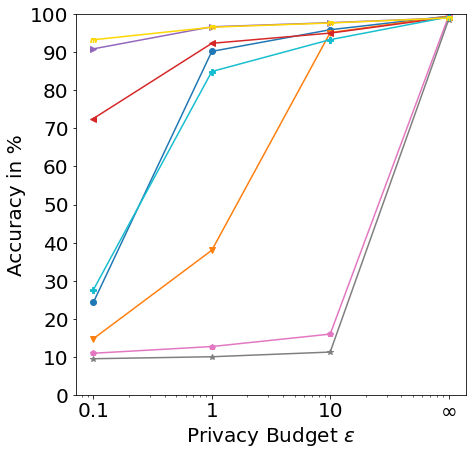

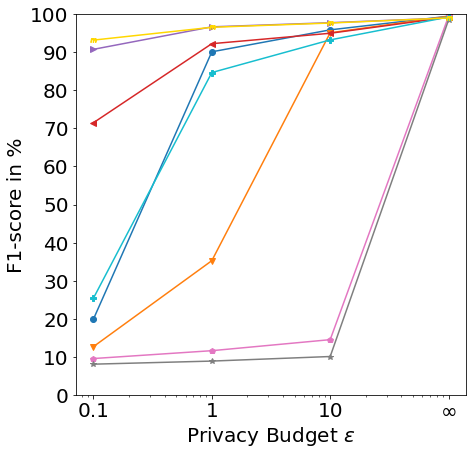

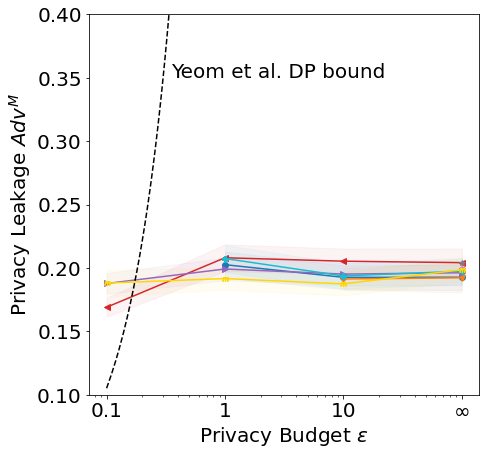

covid


<Figure size 2160x2160 with 0 Axes>

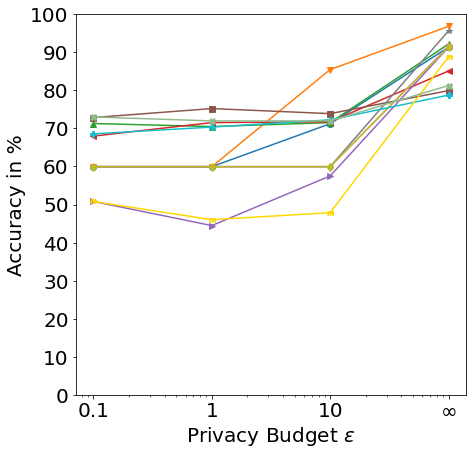

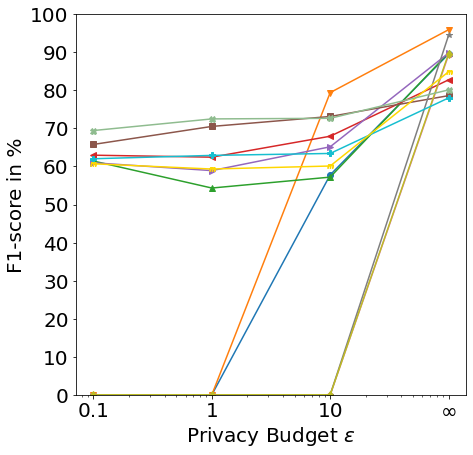

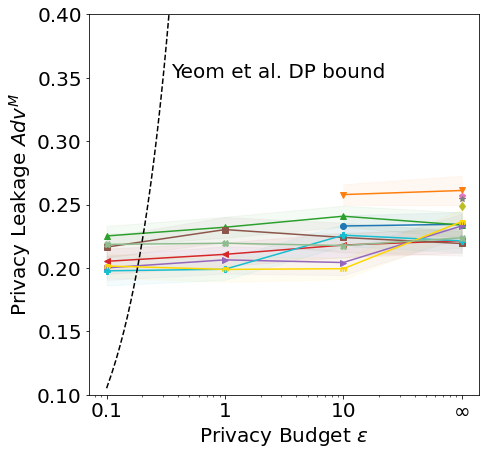

<Figure size 2160x2160 with 0 Axes>

In [ ]:
plot_df(runs_df, markers=MARKERS, colors=COLORS)